In [2]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
from torchvision import transforms, datasets
import os
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
import matplotlib.pyplot as plt
from PIL import Image

/home/datnguyenthanh/datnt_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Wrangling
Summary: 
- Extracted filepath and class_id from .txt file
- Developed LightningDataModule for training, validation, testing

In [3]:
m_path = '/home/tungnguyendinh/.fastai/data/oxford-iiit-pet'
print(os.listdir(m_path))

['images', 'annotations']


In [4]:
df = pd.read_csv(f"{m_path}/annotations/trainval.txt", sep = " ", header=None)
df.columns = ["file", "class", "type", "breed"]
len(df)

3680

In [5]:
#Neccessary functions

def encode_label(label, classes = range(1,38)):
    return label - 1

def decode_target(target, classes = range(1,38)):
    return target + 1

def load_image(filename):
    img = Image.open(filename)
    img = img.convert('RGB')
    return img

In [6]:
class OxfordPetDataset(Dataset):
    def __init__(self, img_dir, annotations_file, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, sep = " ", header=None)               
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{self.img_labels.iloc[idx, 0]}.jpg")
        image = load_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, encode_label(label)

In [7]:
class OxfordPetDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir):
        super().__init__()
        self.batch_size = batch_size
        self.data_dir = data_dir
        self.mean = [0.457342265910642, 0.4387686270106377, 0.4073427106250871]
        self.std = [0.26753769276329037, 0.2638145880487105, 0.2776826934044154]  
        self.train_transform = transforms.Compose([
                transforms.Resize((300, 300)),
                transforms.RandomChoice([
                                        transforms.ColorJitter(brightness=(0.9, 1.1)),
                                        transforms.RandomGrayscale(p = 0.25)
                                        ]),
                transforms.RandomHorizontalFlip(p = 0.25),
                transforms.RandomRotation(25),
                transforms.ToTensor(), 
                transforms.Normalize(mean = self.mean, std = self.std)
                ])
        
        self.eval_transform = transforms.Compose([
                    transforms.Resize((300, 300)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean = self.mean, std = self.std)
                   ])
        
    def setup(self):
        stage = "trainval"
        oxford_full = OxfordPetDataset(f"{self.data_dir}/images/", f"{self.data_dir}/annotations/{stage}.txt", transform=self.train_transform)
        generator = torch.Generator().manual_seed(42)
        self.data_train, self.data_val = random_split(oxford_full, [3569, 111], generator=generator)
        stage = "test"                       
        self.data_test = OxfordPetDataset(f"{self.data_dir}/images/", f"{self.data_dir}/annotations/{stage}.txt", transform=self.eval_transform)
            
    def train_dataloader(self):
        return DataLoader(self.data_train, self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.data_val, self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.data_test, self.batch_size, shuffle=True)

In [8]:

BATCH_SIZE = 16
oxford = OxfordPetDataModule(BATCH_SIZE, m_path)
oxford.setup()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

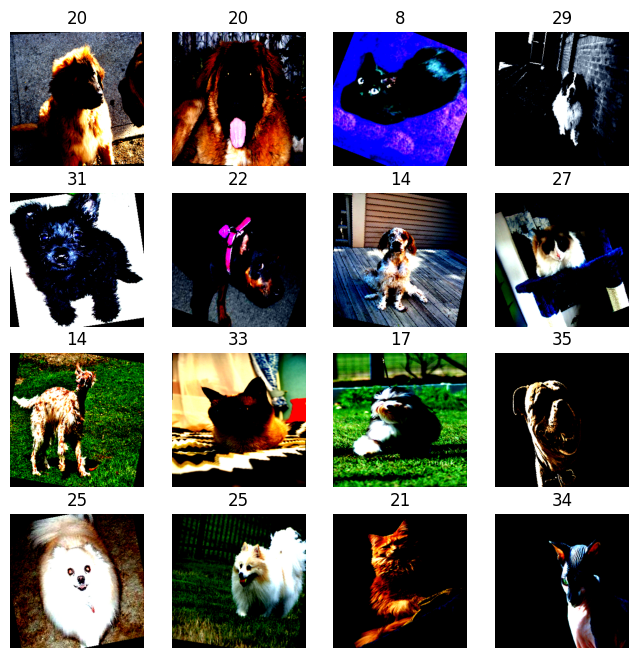

In [9]:
#Visualize some train data

figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(oxford.data_train), size=(1,)).item()
    img, label = oxford.data_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    title = f"{decode_target(label)}" 
    plt.title(title) 
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1,2,0), cmap="gray")
plt.show()
del figure

## Model Building:
Summary: 
- Reuse ResNet model from previous exercises
- Reuse callbacks to log loss, accuracy, learning_rate, load pretrained weights from previous exercises
- Log filter visualizations to TensorBoard
- Use localhost:6008 on any browser to view TensorBoard

In [10]:
from pytorch_lightning.utilities.types import EPOCH_OUTPUT
from torchmetrics.classification import Accuracy

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(
            out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))

        x = self.relu(self.batch_norm2(self.conv2(x)))

        x = self.conv3(x)
        x = self.batch_norm3(x)

        # downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        # add identity
        x += identity
        x = self.relu(x)

        return x


class Block(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.batch_norm2(self.conv1(x)))
        x = self.batch_norm2(self.conv2(x))

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        x += identity
        x = self.relu(x)
        return


class ResNet(pl.LightningModule):
    def __init__(self, ResBlock, layer_list, num_classes, lr = 1e-3 ,num_channels=3):
        super(ResNet, self).__init__()
        self.mca = Accuracy(multiclass=True , num_classes=num_classes)

        self.loss_fn = nn.CrossEntropyLoss()
        self.learning_rate = lr
        self.in_channels = 64

        self.conv1 = nn.Conv2d(
            num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(
            ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(
            ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(
            ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
    
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion,
                          kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes,
                      i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion

        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), self.learning_rate, momentum = 0.9)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 12, eta_min=0, last_epoch=-1)
        return [optimizer], [scheduler]
    
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch

        pred = self.forward(X)
        loss = self.loss_fn(pred, y)
        tmp_pred = pred.detach()
        tmp_y    = y.detach()
        # corrects = (tmp_pred == tmp_y)
        # acc = corrects.sum().float() / float(tmp_y.size(0))
        acc = self.mca(tmp_pred, tmp_y)
        batch_dictionary = {
            "loss" : loss,
            "acc"  : acc
            }
        if (batch_idx % 50 == 0):    
            print(f"loss: {loss:>7f}, training accuracy: {100*acc.item():>0.1f}%")       
             
        return batch_dictionary
    
    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        pred = self.forward(X)
        loss = self.loss_fn(pred, y)
        pred = torch.argmax(pred, 1)
        acc = self.mca(pred, y)
        batch_dictionary = {
            "loss" : loss,
            "acc"  : acc
            }
        return batch_dictionary
                    
    
def ResNet34(num_classes, lr = 1e-3, channels=3):
    return ResNet(Block, [3, 4, 6, 3], num_classes, lr, channels)

def ResNet50(num_classes, lr = 1e-3, channels=3):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes, lr, channels)

In [11]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, LearningRateMonitor

class ResNetCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_outputs = []
        self.val_outputs = []
    
    def on_fit_start(self, trainer, pl_module):
        pretrained_dict = torch.load('runs/ResNet50_Pretrained_Standardized_exp0/model.pth')
        model_dict = pl_module.state_dict()
        pretrained_dict = {k:v for k, v in pretrained_dict.items() if ((k in model_dict) and not ("fc" in k))}
        model_dict.update(pretrained_dict)
        pl_module.load_state_dict(model_dict)
        
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, unused = 0):
        self.train_outputs.append(outputs)
        
    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, unused=0):
        self.val_outputs.append(outputs)
    
    def on_train_epoch_end(self, trainer, pl_module):
        avg_loss = torch.stack([x['loss'] for x in self.train_outputs]).mean()
        avg_acc  = torch.stack([x['acc'] for x in self.train_outputs]).mean()
        
        pl_module.logger.experiment.add_scalar("Loss/train",
                                          avg_loss,
                                          pl_module.current_epoch)
        
        pl_module.logger.experiment.add_scalar("Accuracy/train",
                                          avg_acc,
                                          pl_module.current_epoch)
        
    
    def on_validation_epoch_end(self, trainer, pl_module):
        avg_loss = torch.stack([x['loss'] for x in self.val_outputs]).mean()
        avg_acc  = torch.stack([x['acc'] for x in self.val_outputs]).mean()

        #Logging to tensorboard
        pl_module.logger.experiment.add_scalar("Loss/validation",
                                          avg_loss,
                                          pl_module.current_epoch)
        
        pl_module.logger.experiment.add_scalar("Accuracy/validation",
                                          avg_acc,
                                          pl_module.current_epoch)

In [12]:
model = ResNet50(37, lr=1e-2)
logger = TensorBoardLogger('runs', name='ResNet50_Pretrained_Lightning_OxfordPet', version='auto_find_lr')
trainer = pl.Trainer(accelerator="gpu"
                     , max_epochs=20
                     , devices=[1]
                     , progress_bar_refresh_rate=1
                     , logger=logger
                     , callbacks=[ResNetCallback(),LearningRateMonitor(logging_interval='epoch')]
                     , auto_lr_find=True
                     #, accumulate_grad_batches = 2
                     , limit_train_batches = 10
                     #, num_sanity_val_steps = 2
                     )
trainer.fit(model, oxford.train_dataloader(), oxford.val_dataloader())

/home/datnguyenthanh/datnt_venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

   | Name        | Type              | Params
---------------------------------------------------
0  | mca         | Accuracy          | 0     
1  | loss_fn     | CrossEntropyLoss  | 0     
2  | conv1       | Conv2d            | 9.4 K 
3  | batch_norm1 | BatchNorm2d       | 128   
4  | relu        | ReLU              | 0     
5  | max_pool

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/home/datnguyenthanh/datnt_venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/datnguyenthanh/datnt_venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/datnguyenthanh/datnt_venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:393: UserWarning: The number of training samples (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 19: 100%|██████████| 17/17 [00:09<00:00,  1.86it/s, loss=3.67, v_num=d_lr]


In [13]:
#Get predictions from model on test data

mca = Accuracy(multiclass = True, num_classes=37)
test_data = next(iter(oxford.test_dataloader()))
model.eval()
preds = []
gt    = []
with torch.no_grad():
    X, y = test_data
    out = model(X)
    print(mca(out, y))
    # print(out)
    # print(out.shape)
    # print(nn.Softmax(dim=0)(out))
    pred = torch.argmax(out, 1)
    print(mca(pred, y))
    corrects = (pred == y)
    acc = corrects.sum().float() / float(y.size(0))
    print(acc)
    preds.append(pred)
    gt.append(y) 

tensor(0.0625)
tensor(0.0625)
tensor(0.0625)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

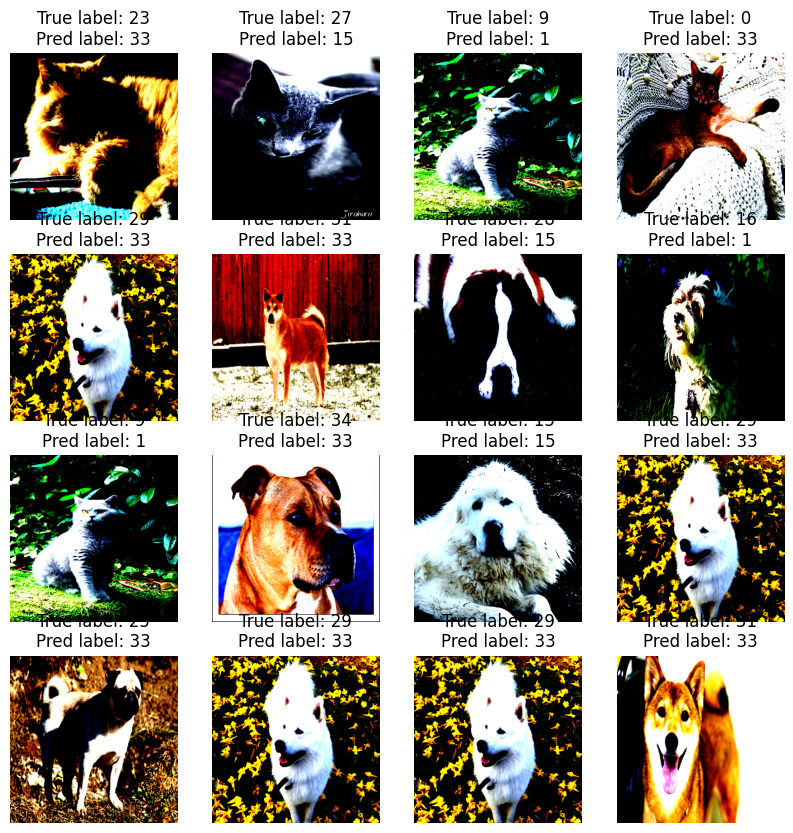

In [14]:
#Visualize predictions by model

figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(preds[0]), size=(1,)).item()
    img = test_data[0][sample_idx]
    label = gt[0][sample_idx]
    pred  = preds[0][sample_idx]
    figure.add_subplot(rows, cols, i)
    title = f"True label: {label}\nPred label: {pred}"
    plt.title(title)
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0), cmap="gray")
plt.show()

In [15]:
#Log computation graph to TensorBoard
sampleImg = torch.rand((1,3,300,300))
logger.experiment.add_graph(model, sampleImg)

/home/datnguyenthanh/datnt_venv/lib/python3.8/site-packages/torch/_jit_internal.py:505: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  item = getattr(mod, name)
/home/datnguyenthanh/datnt_venv/lib/python3.8/site-packages/torch/_jit_internal.py:505: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  item = getattr(mod, name)


In [16]:
import numpy as np

def makegrid(output, numrows):
    outer = (torch.Tensor.cpu(output).detach())
    plt.figure(figsize=(20,5))
    b = np.array([]).reshape(0, outer.shape[2])
    c = np.array([]).reshape(numrows*outer.shape[2], 0)
    i=0
    j=0
    while(i<outer.shape[1]):
        img = outer[0][i]
        b = np.concatenate((img,b), axis=0)
        j += 1
        if (j == numrows):
            c = np.concatenate((c,b), axis=1)
            b = np.array([]).reshape(0, outer.shape[2])
            j = 0
        i += 1
    return c

def ActivationMaps(pl_module, x, device = 1):
        pl_module.logger.experiment.add_image("input", torch.Tensor.cpu(x[0]), pl_module.current_epoch, dataformats="CHW")
        
        out = pl_module.relu(pl_module.batch_norm1(pl_module.conv1(x)))
        out = pl_module.max_pool(out)
        c = makegrid(out, 4)
        pl_module.logger.experiment.add_image("layer0", c, pl_module.current_epoch, dataformats="HW")
        
        out = pl_module.layer1(out)
        c = makegrid(out, 4)
        pl_module.logger.experiment.add_image("layer1", c, pl_module.current_epoch, dataformats="HW")
        
        out = pl_module.layer2(out)
        c = makegrid(out, 4)
        pl_module.logger.experiment.add_image("layer2", c, pl_module.current_epoch, dataformats="HW")

        out = pl_module.layer3(out)
        c = makegrid(out, 4)
        pl_module.logger.experiment.add_image("layer3", c, pl_module.current_epoch, dataformats="HW")

        out = pl_module.layer4(out)
        c = makegrid(out, 4)
        pl_module.logger.experiment.add_image("layer4", c, pl_module.current_epoch, dataformats="HW")


In [17]:
#Log activation map to TensorBoard
sample_img = next(iter(oxford.train_dataloader()))[0]
ActivationMaps(model, sample_img)

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

In [18]:
! tensorboard --logdir=runs --port=6007

TensorFlow installation not found - running with reduced feature set.
/home/datnguyenthanh/datnt_venv/lib/python3.8/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /home/datnguyenthanh/datnt_venv/lib/python3.8/site-packages/tensorboard_data_server/bin/server)
/home/datnguyenthanh/datnt_venv/lib/python3.8/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /home/datnguyenthanh/datnt_venv/lib/python3.8/site-packages/tensorboard_data_server/bin/server)
/home/datnguyenthanh/datnt_venv/lib/python3.8/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /home/datnguyenthanh/datnt_venv/lib/python3.8/site-packages/tensorboard_data_server/bin/server)
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://loc